In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from collections import Counter

In [2]:
# Load data
data = pd.read_csv("C:\\Users\\LENOVO\\Downloads\\Online_Payments_Fraud_Detection.csv")
print(data.head())
print(data.info())
print(data['isFraud'].value_counts())
fraudulent_transactions = data[data['isFraud'] == 1].head(3)
print(fraudulent_transactions)
duplicate_rows = data[data.duplicated()]

if not duplicate_rows.empty:
    print("Duplicate rows found:")
    print(duplicate_rows)
else:
    print("No duplicate rows found.")


   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 co

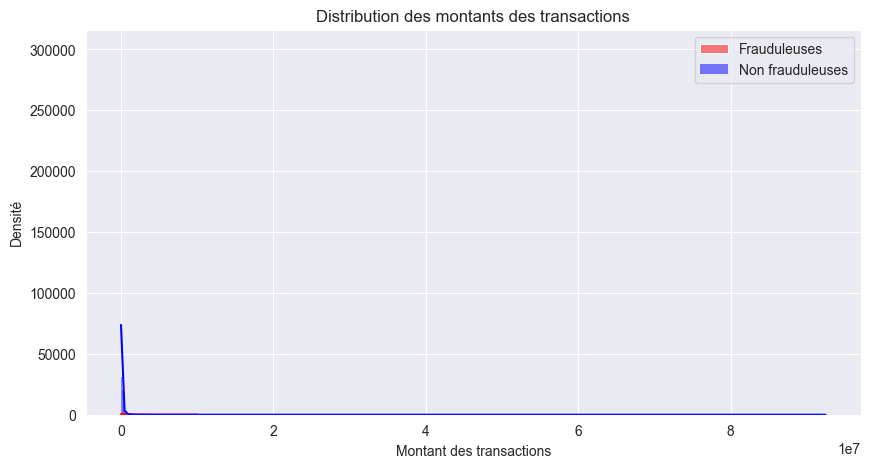

In [3]:
# Visualize transaction amounts
plt.figure(figsize=(10, 5))
sns.histplot(data[data['isFraud'] == 1]['amount'], color='red', label='Frauduleuses', kde=True)
sns.histplot(data[data['isFraud'] == 0]['amount'], color='blue', label='Non frauduleuses', kde=True)
plt.title('Distribution des montants des transactions')
plt.xlabel('Montant des transactions')
plt.ylabel('Densité')
plt.legend()
plt.savefig('distribution_transactions.png')
plt.show()
plt.close()

In [4]:
# Split Train/Test
X = data.drop(['isFraud', 'type', 'nameOrig', 'nameDest', 'step'], axis=1)
y = data['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)


In [5]:
# Définir le ratio cible pour la classe minoritaire (fraud)
fraud_ratio = 0.06  

# Calculer le sampling_strategy en fonction du ratio désiré
current_fraud_count = sum(y_train == 1)
current_non_fraud_count = sum(y_train == 0)

# Calculer le nombre d'échantillons à générer pour la classe minoritaire
desired_fraud_count = int(len(X_train) * fraud_ratio)

# Calculer le sampling_strategy en fonction du nombre actuel de fraudes
sampling_strategy = {
    0: current_non_fraud_count,
    1: desired_fraud_count
}

# Initialiser et appliquer ADASYN avec le sampling_strategy calculé
adasyn = ADASYN(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Vérifier la forme des données resamplées
print("Resampled dataset shape:", Counter(y_train_resampled))

Resampled dataset shape: Counter({0: 4765805, 1: 286635})


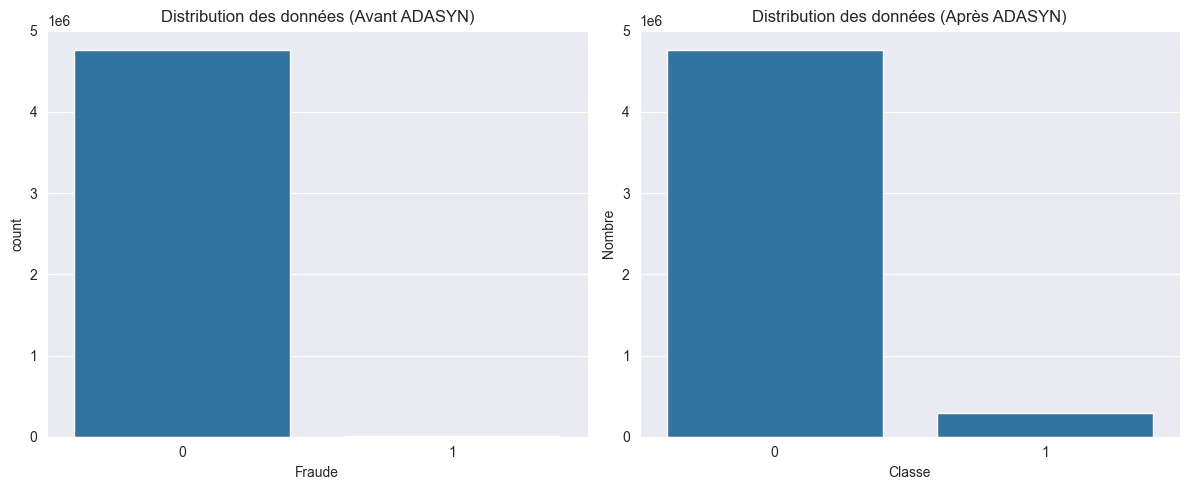

In [6]:

# Distribution des données avant et après ADASYN    
plt.figure(figsize=(12, 5))

# Distribution avant ADASYN
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Distribution des données (Avant ADASYN)')
plt.xlabel('Fraude')

# Distribution après SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_resampled)
plt.title('Distribution des données (Après ADASYN)')
plt.xlabel('Classe')
plt.ylabel('Nombre')
plt.tight_layout()
plt.savefig('distribution_avant_apres_adasyn.png')
plt.show()

In [7]:
# Vérification des valeurs manquantes
print(X_train_resampled.isnull().sum())

amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFlaggedFraud    0
dtype: int64


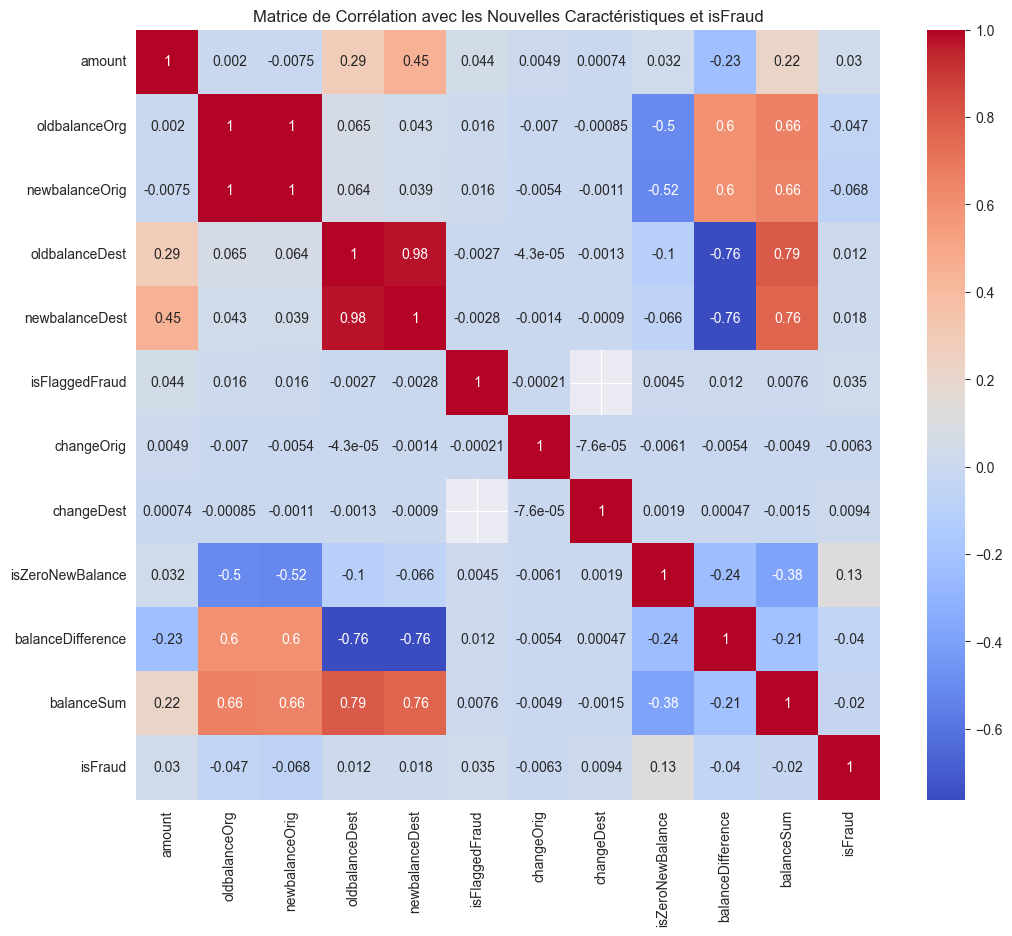

In [8]:
# Ajout de nouvelles caractéristiques
X_train_resampled['changeOrig'] = (X_train_resampled['newbalanceOrig'] - X_train_resampled['oldbalanceOrg']) / X_train_resampled['oldbalanceOrg']
X_train_resampled['changeDest'] = (X_train_resampled['newbalanceDest'] - X_train_resampled['oldbalanceDest']) / X_train_resampled['oldbalanceDest']
X_train_resampled['isZeroNewBalance'] = (X_train_resampled['newbalanceOrig'] == 0) | (X_train_resampled['newbalanceDest'] == 0)
X_train_resampled['balanceDifference'] = X_train_resampled['oldbalanceOrg'] - X_train_resampled['oldbalanceDest']
X_train_resampled['balanceSum'] = X_train_resampled['oldbalanceOrg'] + X_train_resampled['oldbalanceDest']


# Ajout de la colonne isFraud à X_train_resampled
X_train_resampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)

# Matrice de corrélation avec les nouvelles caractéristiques et isFraud
correlation_matrix = X_train_resampled.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de Corrélation avec les Nouvelles Caractéristiques et isFraud')
plt.savefig('new_matrice_correlation_with_isFraud.png')
plt.show()

In [9]:
# Feature selection
selected_features = ['newbalanceOrig', 'oldbalanceDest', 'newbalanceDest','oldbalanceOrg']

In [10]:
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import joblib

In [11]:
# Function to display metrics
def display_metrics(y_true, y_pred, y_pred_proba=None):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba) if y_pred_proba is not None else None
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if roc_auc:
        print(f"ROC AUC: {roc_auc:.4f}")
    print("\n")

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    }

    return metrics

In [12]:
# Function to train and evaluate a model
def train_and_evaluate(model, X_train, y_train, X_test, y_test, selected_features=None):
    if selected_features is not None:
        X_train = X_train[selected_features]
        X_test = X_test[selected_features]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    return display_metrics(y_test, y_pred, y_pred_proba)

# Logistic Regression Models
models = {
    "Logistic Regression Unbalanced No FS": LogisticRegression(solver='liblinear', max_iter=1000, penalty='l2'),
    "Logistic Regression Balanced No FS": LogisticRegression(solver='liblinear', max_iter=1000, penalty='l2'),
    "Logistic Regression Unbalanced FS": LogisticRegression(solver='liblinear', max_iter=1000, penalty='l2'),
    "Logistic Regression Balanced FS": LogisticRegression(solver='liblinear', max_iter=1000, penalty='l2')
}

In [13]:
# Train and evaluate Logistic Regression models
logistic_metrics = {}
random_forest_metrics = {}
random_forest_metrics_rs= {}
print("Training and evaluating Logistic Regression models...")
for name, model in models.items():
    print(f"Training and evaluating {name}...")
    if "Balanced" in name:
        metrics = train_and_evaluate(model, X_train_resampled, y_train_resampled, X_test, y_test,
                                     selected_features if "FS" in name else None)
    else:
        metrics = train_and_evaluate(model, X_train, y_train, X_test, y_test,
                                     selected_features if "FS" in name else None)
    logistic_metrics[name] = metrics


Training and evaluating Logistic Regression models...
Training and evaluating Logistic Regression Unbalanced No FS...
Accuracy: 0.9398
Precision: 0.0105
Recall: 0.4900
F1 Score: 0.0206
ROC AUC: 0.8014


Training and evaluating Logistic Regression Balanced No FS...
Accuracy: 0.9184
Precision: 0.0148
Recall: 0.9469
F1 Score: 0.0291
ROC AUC: 0.9717


Training and evaluating Logistic Regression Unbalanced FS...
Accuracy: 0.9398
Precision: 0.0105
Recall: 0.4900
F1 Score: 0.0206
ROC AUC: 0.8014


Training and evaluating Logistic Regression Balanced FS...
Accuracy: 0.9184
Precision: 0.0148
Recall: 0.9469
F1 Score: 0.0291
ROC AUC: 0.9717



In [14]:
# Random Forest Models
models_rf = {
    "Random Forest Unbalanced No FS": RandomForestClassifier(random_state=42),
    "Random Forest Balanced No FS": RandomForestClassifier(random_state=42),
    "Random Forest Unbalanced FS": RandomForestClassifier(random_state=42),
    "Random Forest Balanced FS": RandomForestClassifier(random_state=42)
}
# Hyperparameter tuning for Random Forest
param_dist = {
    'n_estimators': [100, 200],            # Nombre d'arbres dans le random forest
    'max_depth': [None, 10, 20],            # Profondeur maximale des arbres
    'min_samples_split': [2, 10],            # Nombre minimum d'échantillons requis pour diviser un nœud
    'min_samples_leaf': [1, 4],              # Nombre minimum d'échantillons requis à chaque feuille
    'bootstrap': [True],                 # Utilisation de bootstrap ou non
    'criterion': ['gini', 'entropy']           # Critère de division
}

# Randomized Search with Cross-Validation
random_search_rf = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42, verbose=2),
                                      param_distributions=param_dist,
                                      n_iter=10,
                                      cv=StratifiedKFold(3),
                                      scoring='accuracy',
                                      random_state=42,
                                      n_jobs=-1,
                                      verbose=2)


In [15]:
print("Training and evaluating Random Forest models without Randomized Search...")
for name, model in models_rf.items():
    print(f"Training and evaluating {name} without Randomized Search...")
    if "Balanced" in name:
        model.fit(X_train_resampled[selected_features], y_train_resampled)
        y_pred = model.predict(X_test[selected_features])
        y_pred_proba = model.predict_proba(X_test[selected_features])[:, 1]
    else:
        model.fit(X_train[selected_features], y_train)
        y_pred = model.predict(X_test[selected_features])
        y_pred_proba = model.predict_proba(X_test[selected_features])[:, 1]

    metrics = display_metrics(y_test, y_pred, y_pred_proba)
    random_forest_metrics[name] = metrics

print("Random Forest Metrics without Randomized Search:")
print(random_forest_metrics)


Training and evaluating Random Forest models without Randomized Search...
Training and evaluating Random Forest Unbalanced No FS without Randomized Search...
Accuracy: 0.9994
Precision: 0.8362
Recall: 0.6366
F1 Score: 0.7229
ROC AUC: 0.9095


Training and evaluating Random Forest Balanced No FS without Randomized Search...
Accuracy: 0.9951
Precision: 0.1867
Recall: 0.8256
F1 Score: 0.3046
ROC AUC: 0.9671


Training and evaluating Random Forest Unbalanced FS without Randomized Search...
Accuracy: 0.9994
Precision: 0.8362
Recall: 0.6366
F1 Score: 0.7229
ROC AUC: 0.9095


Training and evaluating Random Forest Balanced FS without Randomized Search...
Accuracy: 0.9951
Precision: 0.1867
Recall: 0.8256
F1 Score: 0.3046
ROC AUC: 0.9671


Random Forest Metrics without Randomized Search:
{'Random Forest Unbalanced No FS': {'Accuracy': 0.9993700708198824, 'Precision': 0.836212412028151, 'Recall': 0.636629322942036, 'F1 Score': 0.7228982300884956, 'ROC AUC': 0.9095096231660958}, 'Random Forest Bal

In [16]:
# Train and evaluate Random Forest models
print("Training and evaluating Random Forest models...")
for name, model in models_rf.items():
    print(f"Training and evaluating {name}...")
    if "Balanced" in name:
        random_search_rf.fit(X_train_resampled[selected_features], y_train_resampled)
    else:
        random_search_rf.fit(X_train[selected_features], y_train)

    best_model = random_search_rf.best_estimator_
    y_pred = best_model.predict(X_test[selected_features])
    y_pred_proba = best_model.predict_proba(X_test[selected_features])[:, 1]
    metrics = display_metrics(y_test, y_pred, y_pred_proba)
    random_forest_metrics_rs[name] = metrics


Training and evaluating Random Forest models...
Training and evaluating Random Forest Unbalanced No FS...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
bu

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 14.0min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    7.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    7.1s


Accuracy: 0.9995
Precision: 0.9258
Recall: 0.6259
F1 Score: 0.7469
ROC AUC: 0.9720


Training and evaluating Random Forest Balanced No FS...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 3

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 15.4min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    9.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    9.4s


Accuracy: 0.9964
Precision: 0.2424
Recall: 0.8436
F1 Score: 0.3766
ROC AUC: 0.9865


Training and evaluating Random Forest Unbalanced FS...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 13.9min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    7.3s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    7.2s


Accuracy: 0.9995
Precision: 0.9258
Recall: 0.6259
F1 Score: 0.7469
ROC AUC: 0.9720


Training and evaluating Random Forest Balanced FS...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 o

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 16.1min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    9.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    9.1s


Accuracy: 0.9964
Precision: 0.2424
Recall: 0.8436
F1 Score: 0.3766
ROC AUC: 0.9865


In [22]:
# Print the collected metrics
print("Logistic Regression Metrics:")
print(logistic_metrics)
print("\nRandom Forest Metrics:")
print(random_forest_metrics)
print("\nRandom Forest Metrics with Randomized Search:")
print(random_forest_metrics_rs)


Logistic Regression Metrics:
{'Logistic Regression Unbalanced No FS': {'Accuracy': 0.9397656940065571, 'Precision': 0.010504223616752462, 'Recall': 0.49001461276181196, 'F1 Score': 0.020567549885508667, 'ROC AUC': 0.8014218112876833}, 'Logistic Regression Balanced No FS': {'Accuracy': 0.9184166271127303, 'Precision': 0.014771363007765603, 'Recall': 0.9469069654164637, 'F1 Score': 0.029088950239041143, 'ROC AUC': 0.9716836499166809}, 'Logistic Regression Unbalanced FS': {'Accuracy': 0.9397656940065571, 'Precision': 0.010504223616752462, 'Recall': 0.49001461276181196, 'F1 Score': 0.020567549885508667, 'ROC AUC': 0.8014218112876833}, 'Logistic Regression Balanced FS': {'Accuracy': 0.9184166271127303, 'Precision': 0.014771363007765603, 'Recall': 0.9469069654164637, 'F1 Score': 0.029088950239041143, 'ROC AUC': 0.9716836499166809}}

Random Forest Metrics:
{'Random Forest Unbalanced No FS': {'Accuracy': 0.9993700708198824, 'Precision': 0.836212412028151, 'Recall': 0.636629322942036, 'F1 Score

In [23]:
# Convert metrics to DataFrames
logistic_df = pd.DataFrame.from_dict(logistic_metrics, orient='index')
random_forest_df = pd.DataFrame.from_dict(random_forest_metrics, orient='index')
random_forest_df_randomized = pd.DataFrame.from_dict(random_forest_metrics_rs, orient='index')

In [25]:
# Convert dictionaries to DataFrames
logistic_df = pd.DataFrame.from_dict(logistic_metrics, orient='index')
random_forest_df = pd.DataFrame.from_dict(random_forest_metrics, orient='index')
random_forest_df_randomized = pd.DataFrame.from_dict(random_forest_metrics_rs, orient='index')

# Concatenate DataFrames along rows (axis=0)
metrics_df = pd.concat([logistic_df, random_forest_df, random_forest_df_randomized], axis=0)

# Save to CSV
metrics_df.to_csv('model_metrics.csv')

In [27]:
saved_files = [
    joblib.dump(models["Logistic Regression Balanced No FS"], 'logistic_regression_balanced_no_fs_model.pkl'),
    joblib.dump(models["Logistic Regression Balanced FS"], 'logistic_regression_balanced_fs_model.pkl'),
    joblib.dump(models_rf["Random Forest Balanced No FS"], 'random_forest_balanced_no_fs_model.pkl'),
    joblib.dump(models_rf["Random Forest Balanced FS"], 'random_forest_balanced_fs_model.pkl'),
    joblib.dump(random_search_rf.best_estimator_, 'random_forest_balanced_fs_model_rs.pkl')
]
print(saved_files)


[['logistic_regression_balanced_no_fs_model.pkl'], ['logistic_regression_balanced_fs_model.pkl'], ['random_forest_balanced_no_fs_model.pkl'], ['random_forest_balanced_fs_model.pkl'], ['random_forest_balanced_fs_model_rs.pkl']]


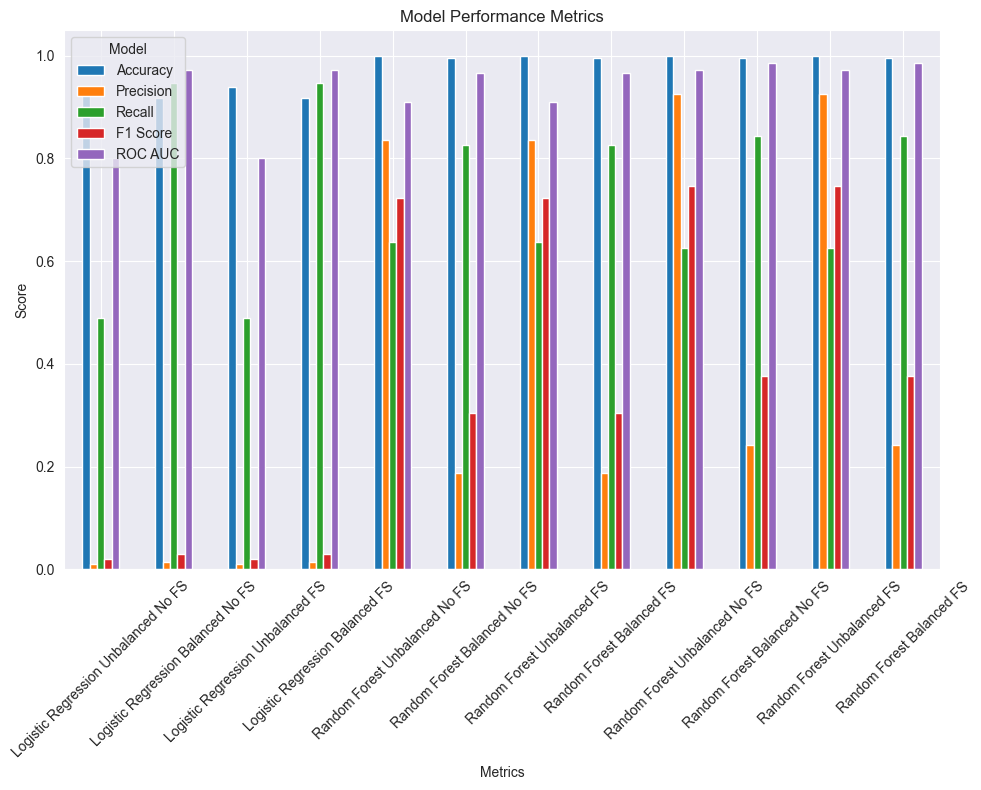

In [38]:
metrics_df.plot(kind='bar', figsize=(10, 8))
plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()

plt.savefig('Performance_Metrics_graph.png')

plt.show()